# About this notebook

This notebook calculates a spectrum for a single photon energy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Multiprocessing
import multiprocessing as mp
from multiprocessing import Pool

# For the progress bar
from ipywidgets import IntProgress
from IPython.display import display

# This package
import XNLdyn

%matplotlib notebook

In [4]:

pulse_energy_max = 1e-6 # Joule

N_local_fluences_to_calculate = 30
N_pulse_energies = 10

Nsteps_r = 100

pulse_profile_sigma= 400 # nm rms



## Set up the problem and modify the parameters a little
PAR = XNLdyn.XNLpars()
PAR.N_photens = 1
PAR.t0_i       = [0,]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [5,]  # Rms pulse duration / fs
PAR.E_i_abs    = [852.5,] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (5,)
PAR.I0_i =  [XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_max]

#* XNLdyn.photons_per_J(PAR.E_i_abs[0])

PAR.Nsteps_z = 30



In [5]:
pulse_energy_max_photons = pulse_energy_max *  XNLdyn.photons_per_J(PAR.E_i[0])


Starting to generate lookup tables for T between 301.0 to 1000300.0 and Ef between -31.6 and 31.6
Lookup tables generated.
Saving at ./fermi_lookup_table.npz


<IPython.core.display.Javascript object>


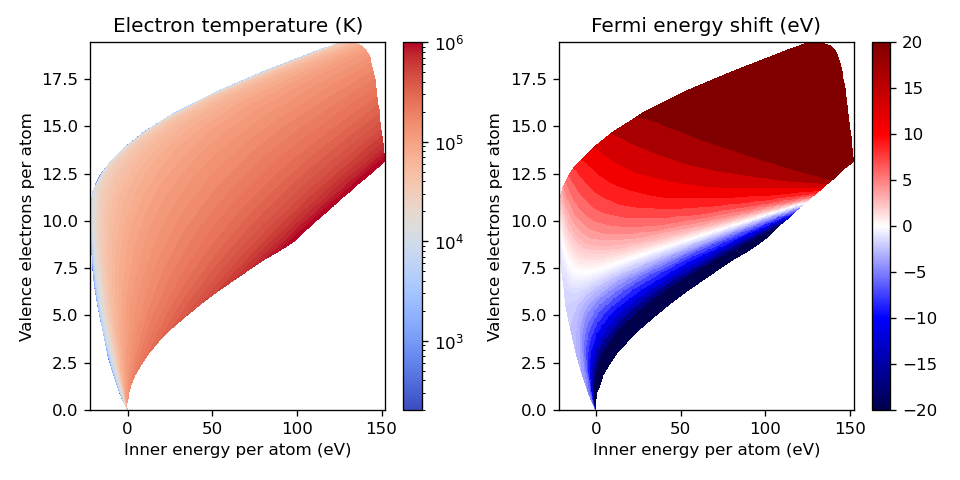

<IPython.core.display.Javascript object>


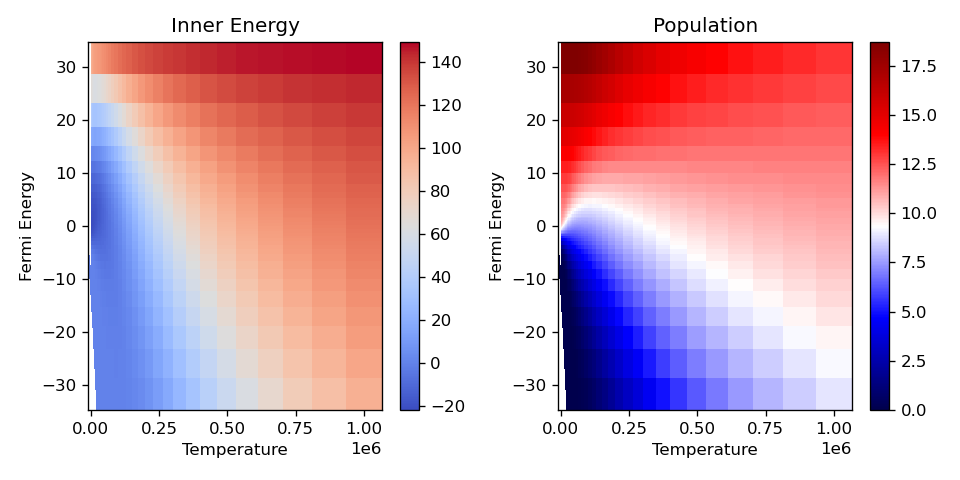

In [6]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True, load_tables = False)
PAR.FermiSolver.plot_lookup_tables()

## Run a simulation for a single Fluence

Initializing a simulation where ['I0_i'] are changed to [22876.639362164755]

Loaded lookup table successfully.


<IPython.core.display.Javascript object>


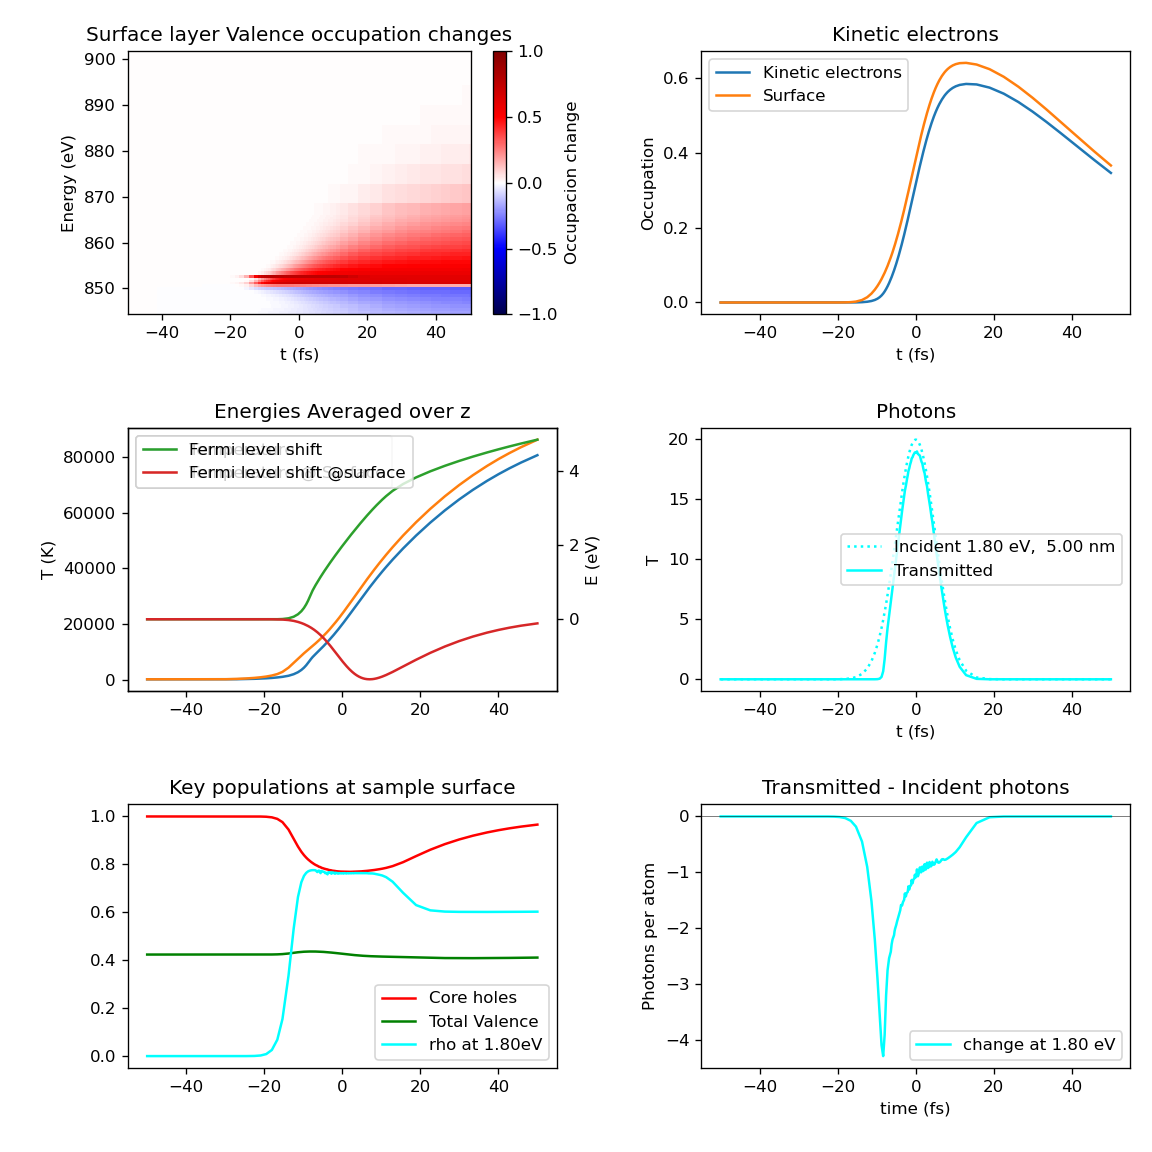

Transmission:  [84.55785389]  %
CPU times: user 3min 8s, sys: 1.02 s, total: 3min 9s
Wall time: 3min 8s


(array([250.81075224]), array([212.08018941]))

In [7]:
%%time
fluences_joules_nm2, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_energy_max, pulse_profile_sigma) 
# These are just to get an idea where to calculate Fluences

fluences_simulated = np.logspace(np.log10(np.min(fluences_joules_nm2)),
                                 np.log10(np.max(fluences_joules_nm2)),
                                 N_local_fluences_to_calculate)

XNLdyn.run_modified_simulation(PAR, dict(t_span=[-50, 50],method='RK45', rtol=1e-3, atol=1e-9, plot = True),
                               ['I0_i',] , [0.5*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0]),])

# Load a spectrum to simulate

<IPython.core.display.Javascript object>


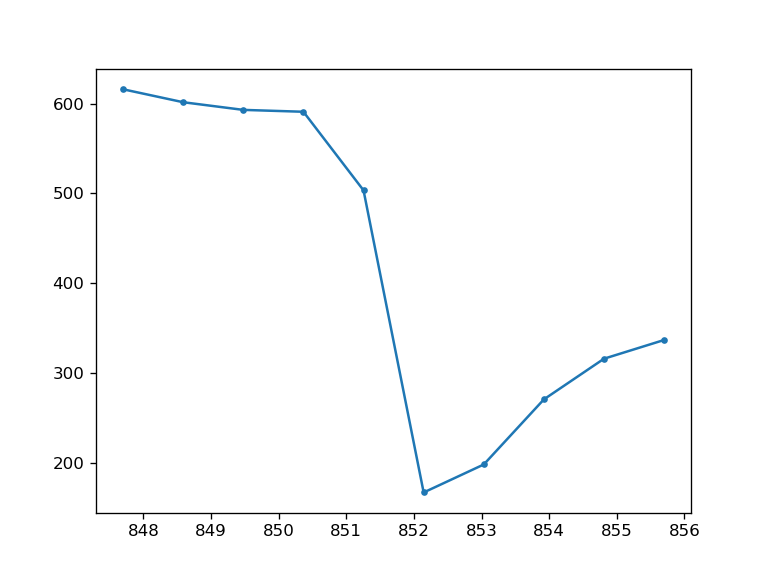

In [11]:

N_points_E = 10
E_fermi = 850.7
Erange = 3
E_min, E_max = E_fermi-Erange, E_fermi+Erange
enax_abs = np.linspace(E_min, E_max+2, N_points_E) # Absolute energy axis to sample
enax_rel = enax_abs-E_fermi # Rélative energy axis to Fermi Energy, i.e. detuning

ld = np.load('../../Penetration_depth_cold_spectrum.npz', allow_pickle=True)
pendepths = np.interp(enax_abs, ld['enax'],ld['spectrum'])

plt.figure()
plt.plot(enax_abs, pendepths,'.-')


## Run it for all the fluences in the spot

In [17]:
sim_options = dict(t_span=[-25, 50],method='RK45', rtol=1e-3, atol=1e-8, plot = False)

In [18]:
%%time
print(f'I will run {N_points_E*N_local_fluences_to_calculate:.0f} Simualtions')

timeout = 300

progressbar = IntProgress(min=0, max=N_points_E*N_local_fluences_to_calculate) # instantiate the bar
display(progressbar) # display the bar

try:
    mp.set_start_method('fork')  # 'spawn' on windows, "fork" or "forkserver" on unix machines
except RuntimeError:
    pass
with Pool(processes=50) as pool:
    tasklist = {}
    for photon_energy, pendepdth in zip(enax_abs, pendepths):
        for fluence in fluences_simulated:
            progressbar.value += 1
            fluence_photons = fluence* XNLdyn.photons_per_J(photon_energy)
            tasklist[(photon_energy,fluence)]=\
                pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,
                                            ['I0_i','E_i', 'lambda_res_Ei'] ,
                                            [(fluence_photons,),(photon_energy,),(pendepdth,)]),)
                                             )


    #tasklist = [pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,  ['I0',] , [fluence,]),)
    #                                     ) for fluence in fluences_simulated]
    resultdict = {key: tasklist[key].get(timeout=timeout) for key in tasklist}


I will run 300 Simualtions


IntProgress(value=0, max=300)

Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.24702418941956167,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.3753775314821583,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.570423048336826,), (847.7,), (615.9438308554943,)]

Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.8668138787878971,), (847.7,), (615.9438308554943,)]

Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(1.3172088726955664,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(2.0016283273337807,), (847.7,), (615.9438308554943,)]
Loaded lookup table successfully.
Loaded lookup table successfully.

Initializ


Loaded lookup table successfully.
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(460.68340232908275,), (848.588888888889,), (601.529422132038,)]

Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(700.0537023011027,), (848.588888888889,), (601.529422132038,)]

Loaded lookup table successfully.
Loaded lookup table successfully.
Transmission:  [92.45269277]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(1063.8003966016702,), (848.588888888889,), (601.529422132038,)]

Loaded lookup table successfully.
Transmission:  [92.27896731]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(1616.54924485081,), (848.588888888889,), (601.529422132038,)]

Loaded lookup table successfully.
Transmission:  [92.27904437]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(2456.5054397194726,), (848.58888


Loaded lookup table successfully.
Transmission:  [92.28476502]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(19884.148806297377,), (849.4777777777779,), (593.0010016460495,)]

Loaded lookup table successfully.
Transmission:  [92.49879528]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(30215.918174128292,), (849.4777777777779,), (593.0010016460495,)]

Loaded lookup table successfully.
Transmission:  [92.76839041]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(45916.05705628525,), (849.4777777777779,), (593.0010016460495,)]

Loaded lookup table successfully.
Transmission:  [92.56632482]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.24624954573042504,), (850.3666666666667,), (590.9036045430806,)]

Loaded lookup table successfully.
Transmission:  [96.04877956]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are chan

Transmission:  [92.18621849]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(1.9932678524176854,), (851.2555555555556,), (503.3899671774383,)]

Loaded lookup table successfully.
Transmission:  [92.18144095]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(3.028966384957785,), (851.2555555555556,), (503.3899671774383,)]

Loaded lookup table successfully.
Transmission:  [92.14579719]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(4.602812085729512,), (851.2555555555556,), (503.3899671774383,)]

Loaded lookup table successfully.
Transmission:  [92.17833457]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(6.994425293641195,), (851.2555555555556,), (503.3899671774383,)]

Loaded lookup table successfully.
Transmission:  [92.20462351]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(10.628716592624903,), (851.25

Transmission:  [92.19538831]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(56.61646296375802,), (852.1444444444445,), (166.96385304359995,)]

Loaded lookup table successfully.
Transmission:  [92.16694411]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(86.03427930893848,), (852.1444444444445,), (166.96385304359995,)]

Loaded lookup table successfully.
Transmission:  [95.11933815]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(130.7375422047571,), (852.1444444444445,), (166.96385304359995,)]

Loaded lookup table successfully.
Transmission:  [92.22280546]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(198.66854327173965,), (852.1444444444445,), (166.96385304359995,)]

Loaded lookup table successfully.
Transmission:  [93.10218736]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(301.8963751353023,), (852

Transmission:  [91.6009376]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(1608.1267565028188,), (853.0333333333334,), (198.14918608982077,)]

Loaded lookup table successfully.
Transmission:  [74.86208537]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(2443.706640976584,), (853.0333333333334,), (198.14918608982077,)]

Loaded lookup table successfully.
Transmission:  [74.8616011]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(3713.4523898723464,), (853.0333333333334,), (198.14918608982077,)]

Loaded lookup table successfully.
Transmission:  [74.86318142]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(5642.955836277395,), (853.0333333333334,), (198.14918608982077,)]

Loaded lookup table successfully.Transmission: 
 [74.8625224]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(8575.025940017977,), (853.0

Transmission:  [78.36388371]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(45677.07584771157,), (853.9222222222222,), (270.64364160252927,)]

Loaded lookup table successfully.
Transmission:  [78.35978042]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.2449692132555161,), (854.8111111111111,), (315.93300639913224,)]

Loaded lookup table successfully.
Transmission:  [78.39391167]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.3722547932534582,), (854.8111111111111,), (315.93300639913224,)]

Loaded lookup table successfully.
Transmission:  [78.49956525]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.5656777407193463,), (854.8111111111111,), (315.93300639913224,)]

Loaded lookup table successfully.
Transmission:  [78.41587868]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(0.859602917530384,), (8


Loaded lookup table successfully.
Transmission:  [83.9581238]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(6.958096750181564,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [85.81309916]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(10.57351180074496,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [88.49886488]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(16.067490265578108,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [83.68114307]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(24.4161304493232,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [84.1389524]  %
Initializing a simulation where ['I0_i', 'E_i', 'lambda_res_Ei'] are changed to [(37.10270964940387,), (855.7,), (336.772391278

## Assemble the results into a Matrix

In [19]:
fl_dep_spectrum_I = np.zeros((N_points_E,N_local_fluences_to_calculate))
fl_dep_spectrum_T = np.zeros((N_points_E,N_local_fluences_to_calculate))

for i_photen in range(N_points_E):
    for i_pulseen in range(N_local_fluences_to_calculate):
        fl_dep_spectrum_I[i_photen, i_pulseen], fl_dep_spectrum_T[i_photen, i_pulseen]  = \
            resultdict[(enax_abs[i_photen],fluences_simulated[i_pulseen])]


<IPython.core.display.Javascript object>


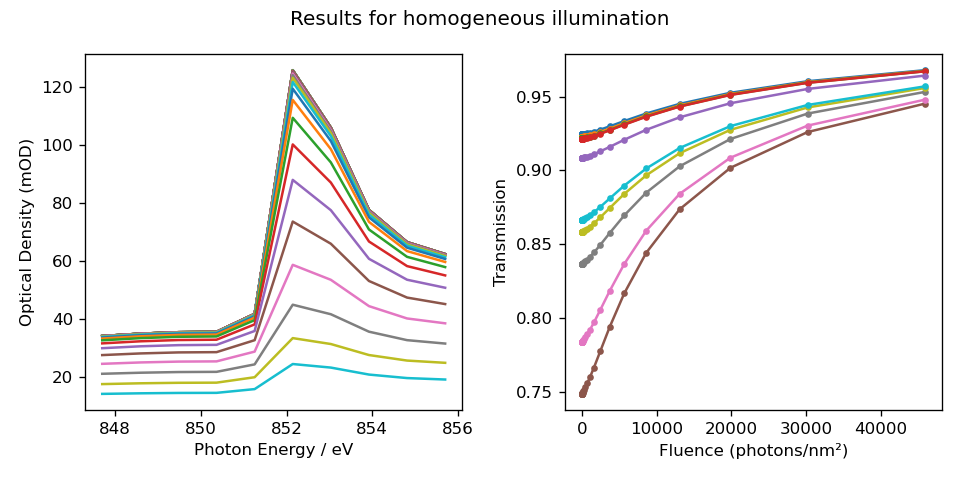

In [20]:
T = fl_dep_spectrum_T/fl_dep_spectrum_I

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for homogeneous illumination')
ax1.plot(enax_abs,1e3*np.log10(1/T))
ax1.set_ylabel('Optical Density (mOD)')
ax1.set_xlabel('Photon Energy / eV')

plt.sca(ax2)
plt.plot(fluences_simulated*XNLdyn.photons_per_J(850), T[:,:].T, '.-')#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm²)')
plt.ylabel('Transmission')
#plt.xscale('log')
#plt.legend(loc = 'lower right')

plt.tight_layout()


<IPython.core.display.Javascript object>


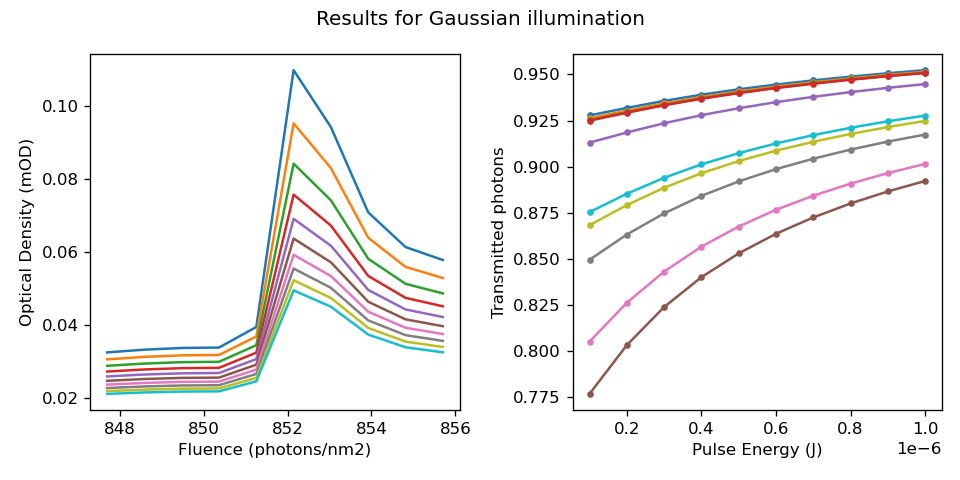

In [21]:
# These are the pulse energies for which we evaluate stuff
final_pulse_energies = np.linspace(1/N_pulse_energies, 1, N_pulse_energies)* pulse_energy_max

final_transmissions = np.zeros((N_points_E, N_pulse_energies))
final_incidence_check = np.zeros((N_points_E, N_pulse_energies))
for i_photen in range(N_points_E):

    for ipe, pulse_en in enumerate(final_pulse_energies*XNLdyn.photons_per_J(enax_abs[i_photen])):
        local_fluences, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_en, pulse_profile_sigma)
        
        
        local_transmitted = np.interp(local_fluences, fluences_simulated*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                      fl_dep_spectrum_T[i_photen,:])# tr[:, 0]
        final_transmissions[i_photen,ipe] = np.sum(local_transmitted*dA)

        
        local_incidence_check = np.interp(local_fluences, fluences_simulated*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                          fl_dep_spectrum_I[i_photen,:])

        final_incidence_check[i_photen,ipe] = np.sum(local_incidence_check*dA) # should result equal final_pulse_energies

        
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for Gaussian illumination')

plt.sca(ax1)
plt.plot(enax_abs,np.log10(final_incidence_check/final_transmissions) )#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm2)')
plt.ylabel('Optical Density (mOD)')

plt.sca(ax2)
plt.plot(final_pulse_energies, (final_transmissions/final_incidence_check).T, '.-')

plt.xlabel('Pulse Energy (J)')
plt.ylabel('Transmitted photons')
#plt.legend(loc = 'lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


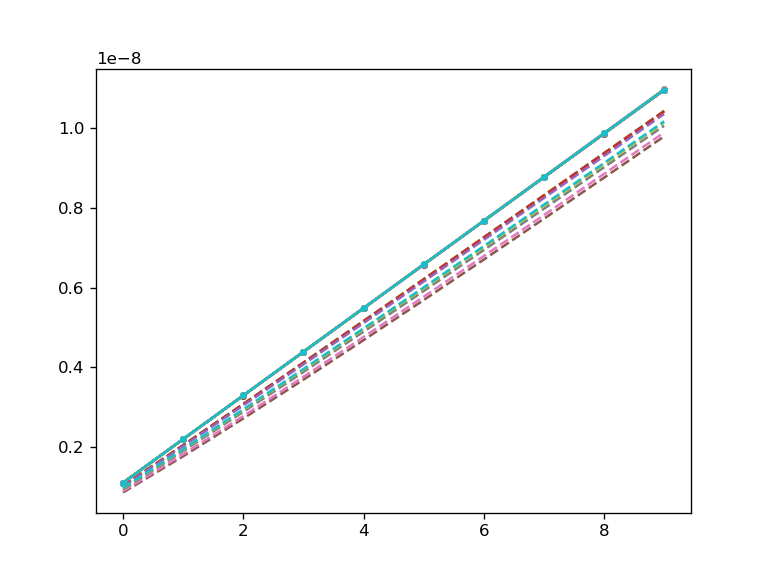

In [23]:
plt.figure()
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_transmissions.T,'--')
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_incidence_check.T,'.-')
#plt.plot(final_pulse_energies,'x')